In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.filters.hp_filter import hpfilter

In [2]:
# Define the file path
file_path = r"C:\Users\belmu\OneDrive\Escritorio\Lucas\Research\Proyects\Banking\wrds\data"
# Read rcon_balanced.csv
df = pd.read_csv(file_path + r"\output\rcon_balanced.csv")
# Read the CSV file adding "\raw\fed_funds_rate.csv" to the file path
df_ffr = pd.read_csv(file_path + r"\raw\fed_funds_rate.csv")
# Read the CSV file adding "\raw\cpi_index" to the file path
df_cpi = pd.read_csv(file_path + r"\raw\cpi_index.csv")
# Read the CSV file adding "\raw\nominal_gdp.csv" to the file path
df_gdp = pd.read_csv(file_path + r"\raw\nominal_gdp.csv")
# Read the CSV file:
df_securities_rcon = pd.read_csv(file_path + r"\output\rcon_securities.csv")
# Read the CSV file:
df_securities_rcfd = pd.read_csv(file_path + r"\output\rcfd_securities.csv")

In [3]:
#what is the minimum date in the dataset?
df['DATE'] = pd.to_datetime(df['DATE'])
min_date = df['DATE'].min()
max_date = df['DATE'].max()

### Add FFR: Make dates consistent first

In [4]:
# Data as date time for df_ffr:
df_ffr['DATE'] = pd.to_datetime(df_ffr['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_ffr['DATE'] = df_ffr['DATE'] - pd.DateOffset(days=1)
# Drop everything before min_date and after max_date:
df_ffr = df_ffr[(df_ffr['DATE'] >= min_date) & (df_ffr['DATE'] <= max_date)]
# Make FFR float:
df_ffr['FEDFUNDS'] = df_ffr['FEDFUNDS'].astype(float)
# Define FEDFUNDS_HIKE if FEDFUNDS is greater than the previous value:
df_ffr['FEDFUNDS_HIKE'] = df_ffr['FEDFUNDS'] > df_ffr['FEDFUNDS'].shift(1)

### Add CPI: Take to real first (1984-03-31=100)

In [5]:
df_cpi['DATE'] = pd.to_datetime(df_cpi['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_cpi['DATE'] = df_cpi['DATE'] - pd.DateOffset(days=1)
# Rename: CPIAUCSL_NBD19840101
df_cpi.rename(columns={'CPIAUCSL_NBD19840101': 'CPI'}, inplace=True)
# Drop everything before min_date and after max_date
df_cpi = df_cpi[(df_cpi['DATE'] >= min_date) & (df_cpi['DATE'] <= max_date)]
# Make CPi float:
df_cpi['CPI'] = df_cpi['CPI'].astype(float)
# Construct 'inflation' as the percentage change in CPI:
df_cpi['INFLATION'] = df_cpi['CPI'].pct_change()
# Construct 'above_average_inflation' as True if inflation is above average:
df_cpi['ABOVE_AVERAGE_INFLATION'] = df_cpi['INFLATION'] > df_cpi['INFLATION'].mean()

### Add Nominal Gdp


In [6]:
df_gdp['DATE'] = pd.to_datetime(df_gdp['DATE'], format='%Y-%m-%d')
# Substract one day from the date:
df_gdp['DATE'] = df_gdp['DATE'] - pd.DateOffset(days=1)
# Rename: NGDPSAXDCUSQ
df_gdp.rename(columns={'NGDPSAXDCUSQ': 'GDP'}, inplace=True)
# Drop everything before min_date and after max_date
df_gdp = df_gdp[(df_gdp['DATE'] >= min_date) & (df_gdp['DATE'] <= max_date)]
# Make GDP float:
df_gdp['GDP'] = df_gdp['GDP'].astype(float)

### Merge all datasets, by date:

In [7]:
df_gdp = df_gdp.merge(df_cpi, on='DATE', how='inner')
df_gdp['REAL_GDP'] = (df_gdp['GDP'] / df_gdp['CPI']) * 100
df_gdp['LOG_REAL_GDP'] = np.log(df_gdp['REAL_GDP'])

lambda_quarterly = 1600
df_gdp['GDP_CYCLE'], df_gdp['GDP_TREND'] = hpfilter(df_gdp['LOG_REAL_GDP'], lamb=lambda_quarterly)

In [8]:
df = df_gdp.merge(df_ffr, on='DATE', how='left')

In [9]:
# Take capslock out of the column names:
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])

In [10]:
# Merge all datasets by date:
df_securities_rcon['date'] = pd.to_datetime(df_securities_rcon['date'])
df_securities_rcon = df_securities_rcon.merge(df, on='date', how='inner')

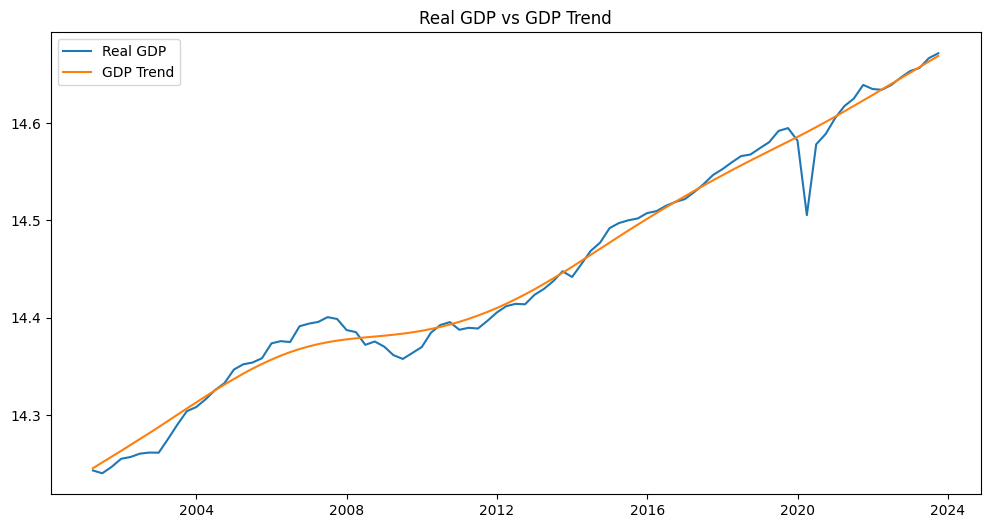

In [11]:
# Keep only log_real_gdp, gdptrend, fedfunds, cpi, gdp, real_gdp on dataframe check:
df_check = df_securities_rcon[['date', 'log_real_gdp', 'gdp_trend', 'fedfunds', 'cpi', 'gdp', 'real_gdp']]
# drop duplicates:
df_check = df_check.drop_duplicates()
df_check = df_check.sort_values(by=['date'])
df['date'] = pd.to_datetime(df['date'])

# plot GDP:
plt.figure(figsize=(12, 6))
plt.plot(df_check['date'], df_check['log_real_gdp'], label='Real GDP')
plt.plot(df_check['date'], df_check['gdp_trend'], label='GDP Trend')
plt.title('Real GDP vs GDP Trend')
plt.legend()

In [12]:
# sort by idrssd and date:
df_securities_rcon = df_securities_rcon.sort_values(by=['idrssd', 'date'])

In [13]:
# Calculate the growth rate of 'total_securities' for each 'idrssd'
df_securities_rcon['securities_growth'] = df_securities_rcon.groupby('idrssd')['total_securities'].pct_change()
# Identify rows where 'total_securities' is zero
zero_mask = df_securities_rcon['total_securities'] == 0
# Shift the zero mask forward and backward to cover periods before and after
zero_mask_expanded = zero_mask | zero_mask.shift(1) | zero_mask.shift(-1)
# Apply the mask to set 'securities_growth' to NaN
df_securities_rcon.loc[zero_mask_expanded, 'securities_growth'] = np.nan
# drop the first observation for each idrssd:
df_securities_rcon = df_securities_rcon.dropna(subset=['securities_growth'])
# describe the securities growth:
df_securities_rcon['securities_growth'].describe()
# show the idrssd with the highest growth rate:
df_securities_rcon[df_securities_rcon['securities_growth'] == df_securities_rcon['securities_growth'].max()]
print(df_securities_rcon['securities_growth'].describe())
print(df_securities_rcon['securities_growth'].quantile(0.99))
# Drop all['securities_growth'] > 0.99 percentile or 0.01 percentile:
df_securities_rcon = df_securities_rcon[df_securities_rcon['securities_growth'] < df_securities_rcon['securities_growth'].quantile(0.99)]
df_securities_rcon = df_securities_rcon[df_securities_rcon['securities_growth'] > df_securities_rcon['securities_growth'].quantile(0.01)]
print(df_securities_rcon['securities_growth'].describe())

count    238829.000000
mean          0.134564
std          20.860384
min          -0.999500
25%          -0.040441
50%          -0.001295
75%           0.056036
max        8014.000000
Name: securities_growth, dtype: float64
0.7603533461183565
count    234075.000000
mean          0.017761
std           0.117770
min          -0.323636
25%          -0.039383
50%          -0.001299
75%           0.054038
max           0.760204
Name: securities_growth, dtype: float64


In [14]:
# Define df_securities_boom if gdp_cycle > 0:
df_securities_rcon['boom'] = np.where(df_securities_rcon['gdp_cycle'] > 0, 1, 0)

In [15]:
# Construct dataframe for boom==1, above_average_inflation==1, fedfunds_hike==1:
df_securities_rcon_boom = df_securities_rcon[(df_securities_rcon['boom'] == 1) &
                                             (df_securities_rcon['above_average_inflation'] == 1) &
                                             (df_securities_rcon['fedfunds_hike'] == 1)]

# Construct dataframe for boom==0, above_average_inflation==1, fedfunds_hike==1:
df_securities_rcon_bust = df_securities_rcon[(df_securities_rcon['boom'] == 0) &
                                             (df_securities_rcon['above_average_inflation'] == 1) &
                                             (df_securities_rcon['fedfunds_hike'] == 1)]

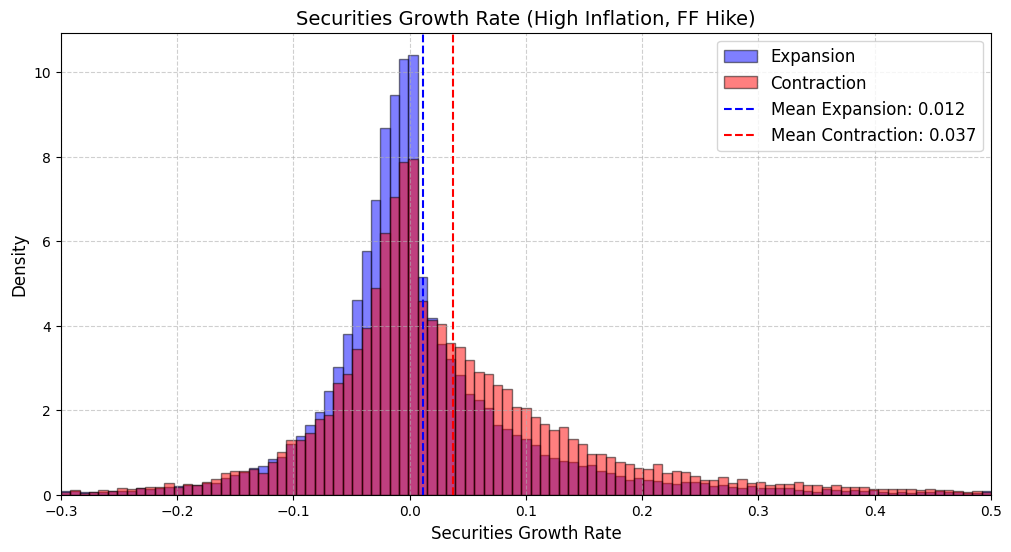

In [16]:
# Define bin edges, for example from -0.3 to 0.5 with 50 bins
bins = np.linspace(-0.3, 0.5, 100)

plt.figure(figsize=(12, 6))

# Plot histograms with density normalization
plt.hist(
    df_securities_rcon_boom['securities_growth'], 
    bins=bins, 
    alpha=0.5, 
    color='blue', 
    label='Expansion',
    fill=True, 
    density=True,
    edgecolor='black'
)
plt.hist(
    df_securities_rcon_bust['securities_growth'], 
    bins=bins, 
    alpha=0.5, 
    color='red', 
    label='Contraction', 
    density=True,
    edgecolor='black'
)

# Plot the mean of each histogram as dashed lines
mean_boom = df_securities_rcon_boom['securities_growth'].mean()
mean_bust = df_securities_rcon_bust['securities_growth'].mean()
st_boom = df_securities_rcon_boom['securities_growth'].std()
st_bust = df_securities_rcon_bust['securities_growth'].std()
plt.axvline(mean_boom, color='blue', linestyle='--', label=f'Mean Expansion: {mean_boom:.3f}')
plt.axvline(mean_bust, color='red', linestyle='--', label=f'Mean Contraction: {mean_bust:.3f}')

# Adding title and labels
plt.title('Securities Growth Rate (High Inflation, FF Hike)', fontsize=14)
plt.xlabel('Securities Growth Rate', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Adding a legend increase size upright:
plt.legend(fontsize=12)

# Displaying grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Setting the x-axis range from -0.3 to 0.5
plt.xlim(-0.3, 0.5)

# save as svg in figures folder:
# path C:\Users\belmu\OneDrive\Escritorio\Lucas\Research\Proyects\Banking\wrds\figures
path = r"C:\Users\belmu\OneDrive\Escritorio\Lucas\Research\Proyects\Banking\wrds"
plt.savefig(path + r"\figures\securities_growth_rate.svg")

# Show the plot
plt.show()


In [17]:
# Bust['dates'] and Boom['dates']:
dates_bust = df_securities_rcon_bust['date'].unique()
dates_boom = df_securities_rcon_boom['date'].unique()

# show all columns and rows:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(dates_boom)
print(dates_bust)

['2004-09-30T00:00:00.000000000' '2005-06-30T00:00:00.000000000'
 '2005-09-30T00:00:00.000000000' '2006-03-31T00:00:00.000000000'
 '2006-06-30T00:00:00.000000000' '2006-12-31T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2017-09-30T00:00:00.000000000'
 '2017-12-31T00:00:00.000000000' '2021-06-30T00:00:00.000000000'
 '2021-12-31T00:00:00.000000000' '2022-09-30T00:00:00.000000000'
 '2022-12-31T00:00:00.000000000' '2023-06-30T00:00:00.000000000']
['2002-03-31T00:00:00.000000000' '2003-12-31T00:00:00.000000000'
 '2004-03-31T00:00:00.000000000' '2016-12-31T00:00:00.000000000'
 '2020-06-30T00:00:00.000000000' '2022-03-31T00:00:00.000000000'
 '2022-06-30T00:00:00.000000000' '2023-03-31T00:00:00.000000000']
